# Attention mechanism을 적용한 RNN encoder-decoder 모델
- 기존의 RNN encoder-decoder모델에서 Bahdanau attention mechanism을 적용한 모델을 살펴봅시다.
- 이번 실습에서는 다양한 날짜 표기법을 년도-월-일의 표준형태로 바꿔주는 작업을 할 것입니다.
- 시간상 training을 따로하지 않고 저장된 모델을 불러와서 사용해보도록 하겠습니다.
### Reference
- https://github.com/datalogue/keras-attention


In [1]:
# 필요한 모듈 import
import os

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

from data.reader import Vocabulary

Using TensorFlow backend.


### Model
![Attention mechanism](./Attention_module.png)
- Attention mechanism을 추가한 RNN encoder-decoder 모델은 그림과 같이 decoder 각 time step의 hidden state를 구하는 데 필요한 context vector가 encoder의 hidden state와 attention weight a와의 weighted sum으로 계산됩니다.
- Attention weight는 encoder hidden state와 decoder의 hidden state 간 scoring function을 통해 관계를 찾음으로써 구할 수 있습니다.
- 즉 encoder state들 중 예측하고자하는 output과 관련된 부분을 찾아 그 부분에 더욱 집중을 함으로써 성능을 향상시키는 mechanism이라고 볼 수 있습니다.

In [2]:
from keras.models import Model
from keras.layers import Dense, Embedding, Activation, Permute
from keras.layers import Input, Flatten, Dropout
from keras.layers.recurrent import LSTM
from keras.layers.wrappers import TimeDistributed, Bidirectional
from models.custom_recurrents import AttentionDecoder

def simpleNMT(pad_length=100,
              n_chars=105,
              n_labels=6,
              embedding_learnable=False,
              encoder_units=256,
              decoder_units=256,
              trainable=True,
              return_probabilities=False):
    """
    Builds a Neural Machine Translator that has alignment attention
    :param pad_length: the size of the input sequence
    :param n_chars: the number of characters in the vocabulary
    :param n_labels: the number of possible labelings for each character
    :param embedding_learnable: decides if the one hot embedding should be refinable.
    :return: keras.models.Model that can be compiled and fit'ed

    *** REFERENCES ***
    Lee, Jason, Kyunghyun Cho, and Thomas Hofmann. 
    "Neural Machine Translation By Jointly Learning To Align and Translate" 
    """
    input_ = Input(shape=(pad_length,), dtype='float32')
    input_embed = Embedding(n_chars, n_chars,
                            input_length=pad_length,
                            trainable=embedding_learnable,
                            weights=[np.eye(n_chars)],
                            name='OneHot')(input_)

    rnn_encoded = Bidirectional(LSTM(encoder_units, return_sequences=True),
                                name='bidirectional_1',
                                merge_mode='concat',
                                trainable=trainable)(input_embed)

    y_hat = AttentionDecoder(decoder_units,
                             name='attention_decoder_1',
                             output_dim=n_labels,
                             return_probabilities=return_probabilities,
                             trainable=trainable)(rnn_encoded)

    model = Model(inputs=input_, outputs=y_hat)

    return model

### Attention visualization
- 그렇다면 예시 문장을 입력하여 예측된 sequence의 각 부분이 입력된 sequence의 어떤 부분에 집중하였는지를 쉽게 확인할 수 있는 attention map을 그려보도록 하겠습니다.

In [3]:
def run_example(model, input_vocabulary, output_vocabulary, text):
    encoded = input_vocabulary.string_to_int(text)
    prediction = model.predict(np.array([encoded]))
    prediction = np.argmax(prediction[0], axis=-1)
    return output_vocabulary.int_to_string(prediction)

def run_examples(model, input_vocabulary, output_vocabulary, examples):
    predicted = []
    for example in examples:
        print('~~~~~')
        predicted.append(''.join(run_example(model, input_vocabulary, output_vocabulary, example)))
        print('input:',example)
        print('output:',predicted[-1])
    return predicted

In [4]:
HERE = '.'

SAMPLE_HUMAN_VOCAB = os.path.join(HERE, 'data', 'sample_human_vocab.json')
SAMPLE_MACHINE_VOCAB = os.path.join(HERE, 'data', 'sample_machine_vocab.json')
SAMPLE_WEIGHTS = os.path.join(HERE, 'weights', 'sample_NMT.49.0.01.hdf5')

weights = SAMPLE_WEIGHTS
padding = 50
human_vocab = SAMPLE_HUMAN_VOCAB
machine_vocab = SAMPLE_MACHINE_VOCAB

In [5]:
HERE = '.'
# create a directory if it doesn't already exist
# if not os.path.exists(os.path.join(HERE, 'attention_maps')):
#     os.makedirs(os.path.join(HERE, 'attention_maps'))

SAMPLE_HUMAN_VOCAB = os.path.join(HERE, 'data', 'sample_human_vocab.json')
SAMPLE_MACHINE_VOCAB = os.path.join(HERE, 'data', 'sample_machine_vocab.json')
SAMPLE_WEIGHTS = os.path.join(HERE, 'weights', 'sample_NMT.49.0.01.hdf5')

class Visualizer(object):

    def __init__(self,
                 padding=None,
                 input_vocab=SAMPLE_HUMAN_VOCAB,
                 output_vocab=SAMPLE_MACHINE_VOCAB):
        """
            Visualizes attention maps
            :param padding: the padding to use for the sequences.
            :param input_vocab: the location of the input human
                                vocabulary file
            :param output_vocab: the location of the output 
                                 machine vocabulary file
        """
        self.padding = padding
        self.input_vocab = Vocabulary(
            input_vocab, padding=padding)
        self.output_vocab = Vocabulary(
            output_vocab, padding=padding)

    def set_models(self, pred_model, proba_model):
        """
            Sets the models to use
            :param pred_model: the prediction model
            :param proba_model: the model that outputs the activation maps
        """
        self.pred_model = pred_model
        self.proba_model = proba_model

    def attention_map(self, text):
        """
            Text to visualze attention map for.
        """
        # encode the string
        d = self.input_vocab.string_to_int(text)

        # get the output sequence
        predicted_text = run_example(
            self.pred_model, self.input_vocab, self.output_vocab, text)

        text_ = list(text) + ['<eot>'] + ['<unk>'] * self.input_vocab.padding
        # get the lengths of the string
        input_length = len(text)+1
        output_length = predicted_text.index('<eot>')+1
        # get the activation map
        activation_map = np.squeeze(self.proba_model.predict(np.array([d])))[
            0:output_length, 0:input_length]

        # import seaborn as sns
        plt.clf()
        f = plt.figure(figsize=(8, 8.5))
        ax = f.add_subplot(1, 1, 1)

        # add image
        i = ax.imshow(activation_map, interpolation='nearest', cmap='gray')
        
        # add colorbar
        cbaxes = f.add_axes([0.2, 0, 0.6, 0.03])
        cbar = f.colorbar(i, cax=cbaxes, orientation='horizontal')
        cbar.ax.set_xlabel('Probability', labelpad=2)

        # add labels
        ax.set_yticks(range(output_length))
        ax.set_yticklabels(predicted_text[:output_length])
        
        ax.set_xticks(range(input_length))
        ax.set_xticklabels(text_[:input_length], rotation=45)
        
        ax.set_xlabel('Input Sequence')
        ax.set_ylabel('Output Sequence')

        # add grid and legend
        ax.grid()
        # ax.legend(loc='best')

        # f.savefig(os.path.join(HERE, 'attention_maps', text.replace('/', '')+'.pdf'), bbox_inches='tight')
        f.show()

### Visualization
![Attention visualization](./Example.jpg)
- 예시 그림은 밝기에 따른 attention을 나타낸 것입니다. 즉 여기서는 월을 나타내는 '05'를 예측하기 위해 입력 문구의 'May'부분에 집중이 되었음을 알 수가 있습니다. Attention mechanism은 이처럼 output과 대응하는 input을 찾아 이에 attention을 주기 때문에 어순이 다른 문장에서도 번역이 가능합니다.

Weights loading from: ./weights/sample_NMT.49.0.01.hdf5
Loading models
inputs shape: (?, ?, 512)
inputs shape: (?, ?, 512)
Models loaded
Completed visualizations


/home/geonhee/anaconda3/envs/keras2/lib/python3.4/site-packages/matplotlib/figure.py:457: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


<Figure size 432x288 with 0 Axes>

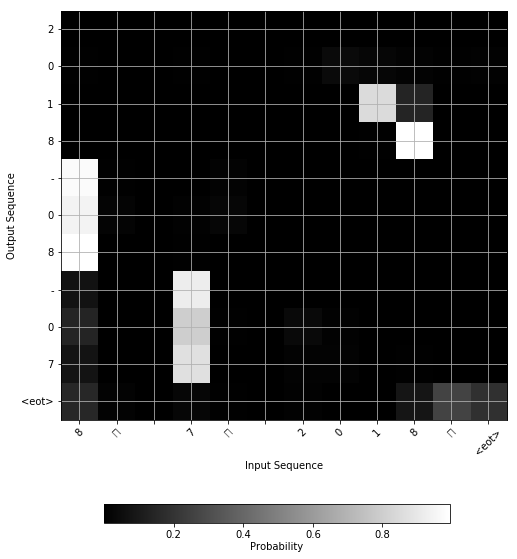

In [6]:
# 여기에 입력 날짜를 넣습니다.
EXAMPLES = ['8월 7일 2018년']
weights_file = os.path.expanduser(weights)
print('Weights loading from:', weights_file)
viz = Visualizer(padding=padding,
                 input_vocab=human_vocab,
                 output_vocab=machine_vocab)
print('Loading models')
# 문장을 예측하기 위해 부르는 모델
pred_model = simpleNMT(trainable=False,
                       pad_length=padding,
                       n_chars=viz.input_vocab.size(),
                       n_labels=viz.output_vocab.size())

pred_model.load_weights(weights_file, by_name=True)
pred_model.compile(optimizer='adam', loss='categorical_crossentropy')

# 이번엔 문장을 예측하기 위해 적용된 attention weight값을 불러오기 위해 return_probabilities=True로 바꾸어 다시 compile합니다.
prob_model = simpleNMT(trainable=False,
                        pad_length=padding,
                        n_chars=viz.input_vocab.size(),
                        n_labels=viz.output_vocab.size(),
                        return_probabilities=True)

prob_model.load_weights(weights_file, by_name=True)
prob_model.compile(optimizer='adam', loss='categorical_crossentropy')

viz.set_models(pred_model, prob_model)

print('Models loaded')

for example in EXAMPLES:
    viz.attention_map(example)

print('Completed visualizations')